In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import psycopg2
import psycopg2.extras
import helper
import seaborn as sns
import calendar
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import style
from datetime import datetime

style.use('ggplot')

%matplotlib inline

In [9]:
%%time
df = pd.read_csv('./data/unipi_ais_clean.csv')

# δημιουργία γεωμετρίας
df = helper.getGeoDataFrame_v2(df, crs='epsg:4326')

Wall time: 11.2 s


In [10]:
df = df.sort_values(by=['mmsi','timestamp'], ascending=[True, True])

In [11]:
df.head()

,timestamp,type,mmsi,status,lon,lat,heading,turn,speed,course,timestamp_sec,velocity,bearing,acceleration,geom
408877,1519997054000,NaN,201100189,NaN,23.380718,37.937533,NaN,NaN,9.6,78.2,1.519997e+09,9.153067,80.288576,-0.008508,POINT (23.38072 37.93753)
408948,1519997075000,NaN,201100189,NaN,23.381822,37.937717,NaN,NaN,9.6,78.3,1.519997e+09,9.331732,80.098539,-0.177391,POINT (23.38182 37.93772)
408983,1519997084000,NaN,201100189,NaN,23.382303,37.937798,NaN,NaN,9.7,78.2,1.519997e+09,10.928250,80.838087,0.120073,POINT (23.38230 37.93780)
409020,1519997095000,NaN,201100189,NaN,23.382995,37.937907,NaN,NaN,9.8,78.8,1.519997e+09,9.607449,78.365172,0.007586,POINT (23.38300 37.93791)
409046,1519997104000,NaN,201100189,NaN,23.383487,37.938005,NaN,NaN,9.6,78.8,1.519997e+09,9.539171,82.562927,0.042909,POINT (23.38349 37.93800)


In [12]:
%%time
points_difference = [0]
time_difference = [0]
for (indx1,row1),(indx2,row2) in zip(df[:-1].iterrows(),df[1:].iterrows()):
    ts = int(row1['timestamp'])
    ts /= 1000
    ts2 = int(row2['timestamp'])
    ts2 /= 1000
    ts_difference = (datetime.utcfromtimestamp(ts2) - datetime.utcfromtimestamp(ts)).total_seconds()
    if row2['mmsi'] != row1['mmsi']:
        points_difference.append(0)
        time_difference.append(0)
    else:
        points_difference.append(helper.haversine([row1['lon'], row1['lat']], [row2['lon'], row2['lat']]) * 1000)
        time_difference.append(ts_difference)

df = df.assign(distance_from_prev=points_difference)
df = df.assign(time_from_prev=time_difference)

Wall time: 2min 39s


In [13]:
df.head()

,timestamp,type,mmsi,status,lon,lat,heading,turn,speed,course,timestamp_sec,velocity,bearing,acceleration,geom,distance_from_prev,time_from_prev
408877,1519997054000,NaN,201100189,NaN,23.380718,37.937533,NaN,NaN,9.6,78.2,1.519997e+09,9.153067,80.288576,-0.008508,POINT (23.38072 37.93753),0.000000,0.0
408948,1519997075000,NaN,201100189,NaN,23.381822,37.937717,NaN,NaN,9.6,78.3,1.519997e+09,9.331732,80.098539,-0.177391,POINT (23.38182 37.93772),98.883630,21.0
408983,1519997084000,NaN,201100189,NaN,23.382303,37.937798,NaN,NaN,9.7,78.2,1.519997e+09,10.928250,80.838087,0.120073,POINT (23.38230 37.93780),43.205920,9.0
409020,1519997095000,NaN,201100189,NaN,23.382995,37.937907,NaN,NaN,9.8,78.8,1.519997e+09,9.607449,78.365172,0.007586,POINT (23.38300 37.93791),61.841753,11.0
409046,1519997104000,NaN,201100189,NaN,23.383487,37.938005,NaN,NaN,9.6,78.8,1.519997e+09,9.539171,82.562927,0.042909,POINT (23.38349 37.93800),44.482487,9.0


Text(0.5, 1, 'Distribution time from prev')

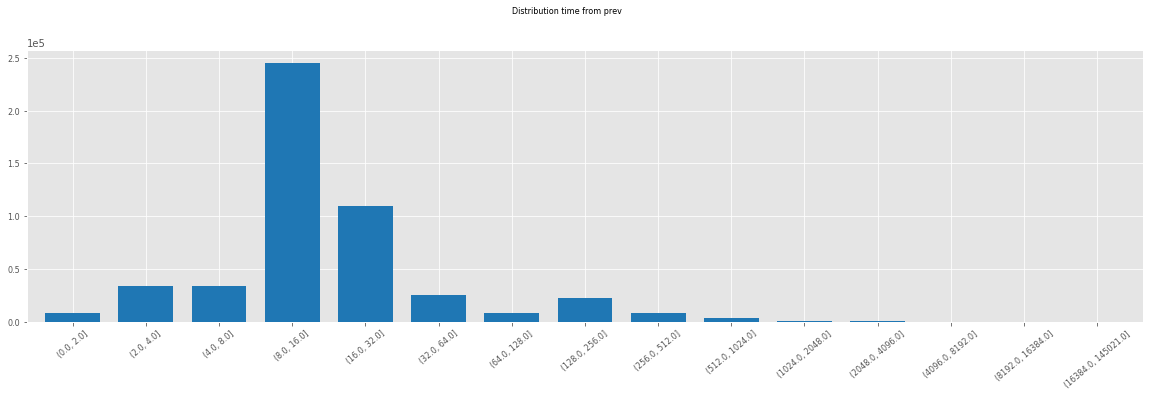

In [14]:
out = pd.cut(df['time_from_prev'], [0, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384, df['time_from_prev'].max()]) 
ax = out.value_counts(sort=False).plot.bar(figsize=(20,5), fontsize=8, width=0.75, cmap='tab20', rot=40)


plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.suptitle(r'Distribution time from prev', fontsize=8, y=1)

Text(0.5, 1, 'Distribution distance from prev')

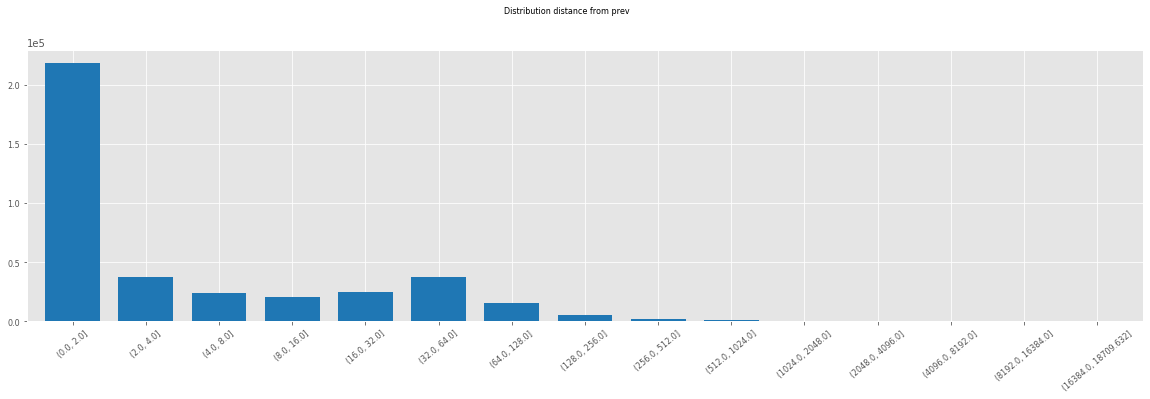

In [15]:
out = pd.cut(df['distance_from_prev'], [0, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384, df['distance_from_prev'].max()]) 
ax = out.value_counts(sort=False).plot.bar(figsize=(20,5), fontsize=8, width=0.75, cmap='tab20', rot=40)


plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.suptitle(r'Distribution distance from prev', fontsize=8, y=1)